# Test Suite for Scaling-up Framework

Simple test with rectangular geometries to validate framework functionality.

## Test Data Structure
- **Base Units**: 4 small rectangles (2x2 grid)
- **Regions**: 2 medium rectangles (left/right)
- **Basin**: 1 large rectangle (contains all)
- **Test CSV**: NDVI data for 2020-2022

In [12]:
%run create_test_data.py

Test data created successfully!
Files created in test:
- base_units.shp (4 rectangles)
- regions.shp (2 regions)
- basin.shp (1 basin)
- test_NDVI_data.csv (temporal data)


D:\Flow MER\mdb-scaling-up\create_test_data.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  base_gdf.to_file(test_dir / "base_units.shp", driver='ESRI Shapefile')
d:\Flow MER\mdb-scaling-up\.venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'HabitatType' to 'HabitatTyp'
  ogr_write(


In [97]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import os
import sys
from pathlib import Path

# Third-party imports
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Local imports
from scaling_up_framework_functions import (
    pivot_year, aggregate_measure_weighted, aggregate_count, standardise_z, normalise,
    SpatialScale, validate_geometries, assign_functional_group, validate_csv_data,
    plot_base_scale, plot_spatial_hierarchy
)
# Import test configuration
from test_config import BASE_SCALE, GROUP_RULES, INCLUDE_UNMATCHED_TYPES, SPATIAL_FILES, DATA_PATH, OUTPUT_PATH, DEFAULT_CRS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# Setup test environment
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Initialize containers
base_scale = None
aggregation_scales = {}
data_cache = {}

In [99]:
# Load test base scale
def load_base_scale() -> SpatialScale:
    base = SpatialScale(
        name=BASE_SCALE["name"],
        source=BASE_SCALE["file"],
        unique_id_field=BASE_SCALE["unique_id"],
        measure_field=BASE_SCALE["measure_field"],
        type_field=BASE_SCALE["type_field"],
        aggregation_method=BASE_SCALE.get("aggregation_method", "geometry"),
        is_base_scale=True
    )
    
    
    
    if BASE_SCALE.get("type_field") is None:
        print("WARNING: type_field not defined - all features will be aggregated together")
        base.data["grp"] = "all_features"
    else:
        base.data["grp"] = base.data[BASE_SCALE["type_field"]].apply(
            lambda x: assign_functional_group(x, BASE_SCALE["name"], GROUP_RULES, INCLUDE_UNMATCHED_TYPES)
        )
        if base.data["grp"].isna().all():
            print(f"No functional groups defined for {BASE_SCALE['name']} - using original type field")
            base.data["grp"] = base.data[BASE_SCALE["type_field"]]
        else:
            print(f"Using functional groups for {BASE_SCALE['name']}")
    return base

base_scale = load_base_scale()
print(f"TEST BASE_SCALE: {base_scale}")
#
# 
# 
# 
# 
# 
# 
# 
# 
# 
# 
# plot_base_scale(base_scale, BASE_SCALE)
print(base_scale.data.head())

Loading BaseUnits data from base_units.shp...
All geometries are valid.
  Detected geometry type: polygon (4 features)
Using functional groups for BaseUnits
TEST BASE_SCALE: BaseUnits (BASE SCALE) - 4 features from base_units.shp
   Area_Ha HabitatTyp   UID  \
0    200.0     Forest  B001   
1    200.0    Wetland  B002   
2    200.0     Forest  B003   
3    200.0  Grassland  B004   

                                            geometry         grp  
0  POLYGON ((-13272678.794 -7539812.629, -1335980...  vegetation  
1  POLYGON ((-13147190.72 -7333008.591, -13233491...       water  
2  POLYGON ((-13359803.54 -7487874.265, -13446338...  vegetation  
3  POLYGON ((-13233491.735 -7279712.72, -13319208...  vegetation  


Loading Regions data from regions.shp...
All geometries are valid.
  Detected geometry type: polygon (2 features)
Loading Regions data from regions.shp...
All geometries are valid.
  Detected geometry type: polygon (2 features)
TEST AGGREGATION_SCALE Regions: 8 intersections
      Area_Ha HabitatTyp         grp  index_right RegionName
UID                                                         
B001    200.0     Forest  vegetation            0       West
B001    200.0     Forest  vegetation            1       East
B002    200.0    Wetland       water            0       West
B002    200.0    Wetland       water            1       East
B003    200.0     Forest  vegetation            0       West
B003    200.0     Forest  vegetation            1       East
B004    200.0  Grassland  vegetation            0       West
B004    200.0  Grassland  vegetation            1       East
Loading Basin data from basin.shp...
All geometries are valid.
  Detected geometry type: polygon (1 features)
Load

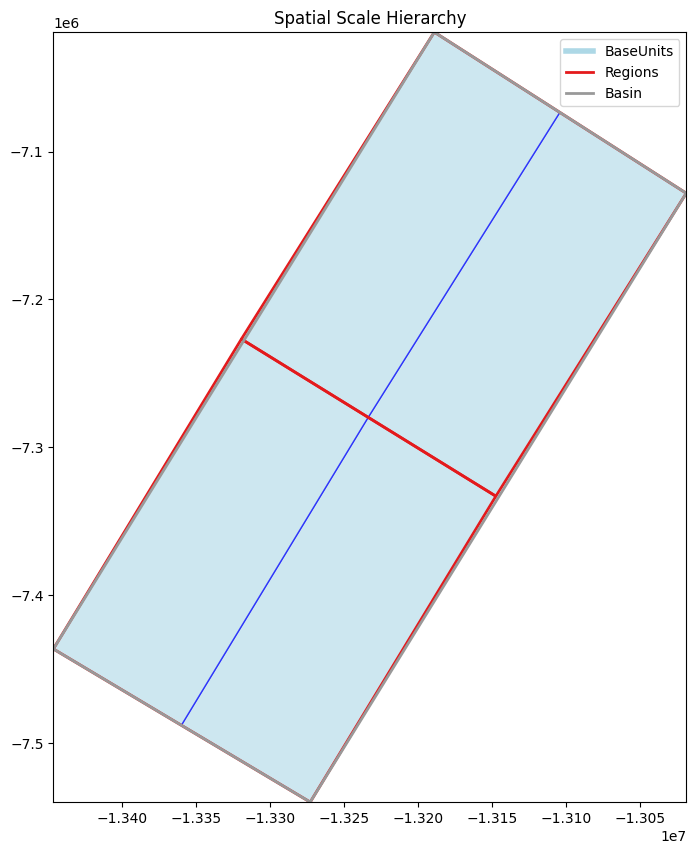

In [100]:
# Load test aggregation scales
def create_aggregation_scale(name: str, source_key: str, unique_field: str) -> pd.DataFrame:
    agg_scale = SpatialScale(name, SPATIAL_FILES[source_key], unique_field)
    # Keep only the unique_field from aggregation scale to avoid polluting base data
    agg_data_clean = agg_scale.data[[unique_field, 'geometry']]
    joined = gpd.sjoin(
        base_scale.data, agg_data_clean,
        how="left", predicate="intersects"
    ).dropna().set_index(BASE_SCALE["unique_id"])
    return joined.drop('geometry', axis=1)

# Test aggregation configs
AGGREGATION_CONFIGS = {
    "Regions": {"source_key": "Regions", "unique_field": "RegionName"},
    "Basin": {"source_key": "Basin", "unique_field": "BasinName"}
}

agg_scale_objects = {}
for scale_name, config in AGGREGATION_CONFIGS.items():
    aggregation_scales[scale_name] = create_aggregation_scale(
        scale_name, config["source_key"], config["unique_field"]
    )
    agg_scale_objects[scale_name] = SpatialScale(scale_name, SPATIAL_FILES[config["source_key"]], config["unique_field"])
    print(f"TEST AGGREGATION_SCALE {scale_name}: {len(aggregation_scales[scale_name])} intersections")
    print(aggregation_scales[scale_name])

plot_spatial_hierarchy(base_scale, BASE_SCALE, agg_scale_objects)

In [101]:
# Load test metric data
def load_metric_data(metric_name: str) -> pd.DataFrame:
    # if metric_name in data_cache:
    #     return data_cache[metric_name]
    
    print(f"Loading test {metric_name} data...")
    csv_files = list(DATA_PATH.glob(f"*{metric_name}*.csv"))
    
    if csv_files:
        csv_file = csv_files[0]
        print(f"Found CSV: {csv_file.name}")
        data = pd.read_csv(csv_file)
        data = validate_csv_data(data, metric_name, BASE_SCALE["unique_id"])
        
        #if year column exists - convert to int
        if "year" in data.columns:
            data["year"] = data["year"].astype(int)
            data = data.sort_values("year")
            #preserve a list of years
            years = data["year"].unique().tolist()
            print(f"Years in data: {years}")
                      
            
            #pivot data to wide format
            data = pivot_year(data, metric_name, BASE_SCALE["unique_id"])

        
    else:
        if metric_name not in base_scale.data.columns:
            raise FileNotFoundError(f"Test metric '{metric_name}' not found")
        data = base_scale.data[[BASE_SCALE["unique_id"], metric_name]].copy().set_index(BASE_SCALE["unique_id"])   

    data_cache[metric_name] = data
    return data

if BASE_SCALE["aggregation_method"] == "count":
    print(f"Using count aggregation method for base scale {BASE_SCALE['name']}. NO additional metric data will be loaded.")
    test_data = base_scale.data
else:
    test_data = load_metric_data("NDVI")
    print(f"Loaded test data: {len(test_data)} records")
    #print(test_data)
    print (test_data.head())

Loading test NDVI data...
Found CSV: test_NDVI_data.csv
Year column detected - will perform temporal analysis
Validation complete: 12 valid records
Years in data: [2020, 2021, 2022]
dict_keys(['count', 'baseline', 'stddev', 'max', 'median', 'mad'])
Loaded test data: 4 records
      2020  2021  2022  NDVI_count  NDVI_baseline  NDVI_stddev  NDVI_max  \
UID                                                                        
B001  0.80  0.82  0.78           3           0.80         0.02      0.82   
B002  0.60  0.58  0.62           3           0.60         0.02      0.62   
B003  0.75  0.77  0.73           3           0.75         0.02      0.77   
B004  0.50  0.52  0.48           3           0.50         0.02      0.52   

      NDVI_median  NDVI_mad  
UID                          
B001         0.80      0.02  
B002         0.60      0.02  
B003         0.75      0.02  
B004         0.50      0.02  


In [103]:


# Process test data
def process_all_scales(data: pd.DataFrame, metric_name: str) -> None:
    aggregated_data = {}
    metric_columns = [] 
    
    #-----------------------------------------------------------------
    # Process the base scale data (building blocks)
    #-----------------------------------------------------------------

    base_data = base_scale.data.drop('geometry', axis=1).set_index(BASE_SCALE["unique_id"])
    if not data.empty:       #join the metric data to the base scale data
        # Ensure metric data has the same unique_id as base scale
        metric_columns = data.select_dtypes(include=[np.number]).columns.values.tolist()
        print(f"Processing {metric_name} for BASE_SCALE ({BASE_SCALE['name']})...")
        aggregated_data[BASE_SCALE["name"]] = base_scale.data.drop('geometry', axis=1).merge(data, how="inner", on=BASE_SCALE["unique_id"]).set_index(BASE_SCALE["unique_id"]).replace([np.inf, -np.inf], np.nan)
    else:
        aggregated_data[BASE_SCALE["name"]] = base_data
        print(f"No data found for {metric_name} - using base scale data only.")

    #-----------------------------------------------------------------
    # Process the range of aggregation scales    
    #-----------------------------------------------------------------

     
    for scale_name, aggregator in aggregation_scales.items():
        print(f"Processing {metric_name} for AGGREGATION_SCALE ({scale_name})...")
        # Get boundary fields from config - convert string to list if needed
        unique_field = AGGREGATION_CONFIGS[scale_name]["unique_field"]
        boundary_fields = [unique_field] if isinstance(unique_field, str) else unique_field
        
        print(aggregator.columns)
        print(aggregator.head())
        # Join the metric data to the aggregation scale data

        print(data.head())
        aggregated_data[scale_name] = aggregate_measure_weighted(
            data, aggregator, boundary_fields, base_scale.measure_field, ["grp"],metric_columns, BASE_SCALE["aggregation_method"]
        )
        # output_file = OUTPUT_PATH / f"{metric_name}_{scale_name}.csv"
        # agg_result.round(4).to_csv(output_file)
        # print(f"Saved: {output_file}")
    for scale_name, agg_data in aggregated_data.items():
        output_file = OUTPUT_PATH / f"{metric_name}_{scale_name}.csv"
        agg_data.round(4).to_csv(output_file)
        print(f"Saved: {output_file}")

    # else:
    #     raise ValueError(f"Unsupported aggregation method: {BASE_SCALE['aggregation_method']}")

       
        
print(test_data)
print("-----------------------------------")
print(base_scale.data.drop('geometry', axis=1).head() )
print("-----------------------------------")
aggregated_data = process_all_scales(test_data, "NDVI")


      2020  2021  2022  NDVI_count  NDVI_baseline  NDVI_stddev  NDVI_max  \
UID                                                                        
B001  0.80  0.82  0.78           3           0.80         0.02      0.82   
B002  0.60  0.58  0.62           3           0.60         0.02      0.62   
B003  0.75  0.77  0.73           3           0.75         0.02      0.77   
B004  0.50  0.52  0.48           3           0.50         0.02      0.52   

      NDVI_median  NDVI_mad  
UID                          
B001         0.80      0.02  
B002         0.60      0.02  
B003         0.75      0.02  
B004         0.50      0.02  
-----------------------------------
   Area_Ha HabitatTyp   UID         grp
0    200.0     Forest  B001  vegetation
1    200.0    Wetland  B002       water
2    200.0     Forest  B003  vegetation
3    200.0  Grassland  B004  vegetation
-----------------------------------
Processing NDVI for BASE_SCALE (BaseUnits)...
Processing NDVI for AGGREGATION_SCALE (Region

In [62]:
base_scale.data.set_index(BASE_SCALE['unique_id'])

,Area_Ha,HabitatTyp,geometry,grp
UID,,,,
B001,200.0,Forest,"POLYGON ((-13272678.794 -7539812.629, -1335980...",vegetation
B002,200.0,Wetland,"POLYGON ((-13147190.72 -7333008.591, -13233491...",water
B003,200.0,Forest,"POLYGON ((-13359803.54 -7487874.265, -13446338...",vegetation
B004,200.0,Grassland,"POLYGON ((-13233491.735 -7279712.72, -13319208...",vegetation


In [40]:
# Test results summary
print("\n=== TEST RESULTS SUMMARY ===")
print(f"BASE_SCALE: {base_scale}")
print("\nAGGREGATION_SCALES:")
for name, data in aggregation_scales.items():
    units = data[AGGREGATION_CONFIGS[name]["unique_field"]].unique()
    groups = data["grp"].unique() if "grp" in data.columns else ["all"]
    print(f"  {name}: {len(data)} records {units} units mapped x {len(groups)} functional groups")

if 'year' in test_data.columns:
    print(f"\nTest data years: {test_data['year'].min()}-{test_data['year'].max()}")
else:
    print(f"\nTest data: Single time point")

print(f"Output files: {len(list(OUTPUT_PATH.glob('*.csv')))}")

print("\nOutput files:")
for file in sorted(OUTPUT_PATH.glob("*.csv")):
    print(f"  {file.name}")
    
print("\n✅ Test suite completed successfully!")


=== TEST RESULTS SUMMARY ===
BASE_SCALE: BaseUnits (BASE SCALE) - 4 features from base_units.shp

AGGREGATION_SCALES:
  Regions: 8 records ['West' 'East'] units mapped x 2 functional groups
  Basin: 4 records ['Test Basin'] units mapped x 2 functional groups

Test data: Single time point
Output files: 3

Output files:
  NDVI_BaseUnits.csv
  NDVI_Basin.csv
  NDVI_Regions.csv

✅ Test suite completed successfully!


In [41]:
data

,Area_Ha,HabitatTyp,grp,index_right,BasinName
UID,,,,,
B001,200.0,Forest,vegetation,0,Test Basin
B002,200.0,Wetland,water,0,Test Basin
B003,200.0,Forest,vegetation,0,Test Basin
B004,200.0,Grassland,vegetation,0,Test Basin
